<a href="https://colab.research.google.com/github/samuel0922/my_gd/blob/main/%5BGD_10%5DCLASS_ACTIVATION_MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD_10]CLASS_ACTIVATION_MAP
## 개요
* CAM : 특성 추출 CNN네트워크 뒤에 GAP과 softmax layer가 붙은 형태로 구성되어야 함
* Grad-CAM : 제약 없음

## 목차
### Part I. 노드
* STEP 0. 환경설정
* STEP 1. 데이터준비
* STEP 2. 모델만들기
* STEP 3. CAM 만들기
* STEP 4. Grad-CAM 만들기
* STEP 5. CAM 활용 Detection

### Part II. 프로젝트 <--- 요기부터
* STEP 0. 환결설정
* STEP 1. CAM
* STEP 2. Grad-CAM

* 루브릭
* 회고

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# PART I. 노드
---

## STEP 0. 환경설정

In [2]:
# # 라이브러리 불러오기

# # TensorFlow and tf.keras
# import tensorflow as tf
# from tensorflow import keras

# # Helper libraries
# import numpy as np
# import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds

# import copy
# import cv2
# from PIL import Image


In [3]:
# # GPU 사용 확인

# tf.config.list_physical_devices('GPU')

## STEP 1. 데이터 준비
* 데이터셋 : tensorflow dataset 중 stanford_dogs dataset
* 학습용 데이터셋 : 12,000
* 평가용 데이터셋 : 8,580

In [65]:
# # 데이터셋 가져오기
# # 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  

# (ds_train, ds_test), ds_info = tfds.load(
#     'stanford_dogs',
#     split=['train', 'test'],
#     shuffle_files=True,
#     with_info=True,
# )


In [66]:
# #  데이터 확인 : 클래스, 인덱스

# tfds.show_examples(ds_train, ds_info)


In [67]:
# # 평가용 데이터셋 확인

# tfds.show_examples(ds_test, ds_info)

In [68]:
# ### 데이터셋의 메타정보 확인 : df_info.features
# * image : 입력 이미지 인덱스
# * label : 정답클래스 인덱스
# * bbox : 물체의 위치를 나타낸 사각형 영역 -> BBoxFeature

In [69]:
# # 세부 정보 확인

# ds_info.features

## STEP 2. 모델 만들기


## S2-1. CAM용 모델 만들기
* 베이스 모델 : ResNet50 pretrained with ImageNet 

In [9]:
# # CAM 용 모델 만들기

# num_classes = ds_info.features["label"].num_classes

# # 베이스 모델 : ResNet50
# base_model = keras.applications.resnet50.ResNet50(
#     include_top=False,    # Imagenet 분류기  fully connected layer 제거

#     # pretrained with ImageNet
#     weights='imagenet',

#     input_shape=(224, 224, 3),

#     # pooling 지정
#     pooling='avg',      # GAP를 적용  
# )

# # 베이스모델에서 아웃풋을 받아서
# x = base_model.output

# # 원하는 레이어를 추가하는 부분
# preds = keras.layers.Dense(num_classes, activation='softmax')(x)

# # CAM을 위한 모델 구성
# # input, outout이 뭔지 지정해줌
# # input : basse_model
# # output: preds
# cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [10]:
# # 모델 확인해 봄

# cam_model.summary()

## S2-2. CAM 모델 학습
* 전처리 : normalization_and _resize_img()
* 배치 구성 : apply_normalize_on_dataset( )


In [11]:
# # 전처리 함수 및 배치 처리

# def normalize_and_resize_img(input):
#     # Normalizes images: `uint8` -> `float32`
#     image = tf.image.resize(input['image'], [224, 224])
#     input['image'] = tf.cast(image, tf.float32) / 255.
#     return input['image'], input['label']

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     ds = ds.batch(batch_size)
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds


In [12]:
# # 데이터셋에 전처리 및 배치처리 적용

# # 데이터셋에 전처리와 배치처리를 적용합니다. 
# ds_train_norm = apply_normalize_on_dataset(ds_train)
# ds_test_norm = apply_normalize_on_dataset(ds_test)

# # 구성된 배치의 모양을 확인해 봅니다. 
# for input in ds_train_norm.take(1):
#     image, label = input
#     print(image.shape)
#     print(label.shape)

In [13]:
# # 모델 컴파일

# cam_model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
#     metrics=['accuracy'],
# )



In [14]:
# # 모델 학습

# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=2,
#     validation_data=ds_test_norm,
#     verbose=1,
#     use_multiprocessing=True,
# )

In [15]:
# # 학습시킨 가중치 저장
# import os

# cam_model_path = '/content/drive/MyDrive/aiffel/class_activation_map/cam_model1.h5'
# cam_model.save(cam_model_path)


## STEP 3. CAM 모델 생성

* 메모리 부족으로 인한 문제를 대비해 커널 재시작함

### S3-1. 데이터 준비하기(일괄)

In [16]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


### S3-2. 이미지 한 장씩 가져오는 함수
* CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, 
* get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 함.



In [17]:
# 이미지 가져오는 함수 정의

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]



40


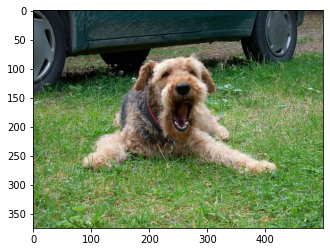

In [18]:
# 이미지 확인

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### S3-3. 학습 모델 불러오기

In [19]:
# 학습된 모델 불러오기

import os
cam_model_path = '/content/drive/MyDrive/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)


### S3-4. model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수
* CAM 생성 위해서는 
 > (1)특성 맵, <br>
 > (2)클래스별 확률을 얻기 위한 softmax layer의 가중치, 그리고<br> 
 > (3) 원하는 클래스의 출력값

  이 필요
* 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면, 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 함

=> 이를 고려해 입력이미지와 동일항 크기의 CAM을 반환하는 함수 만들 필요

In [20]:
# 입력 이미지와 동일한 크기의 CAM을 반환하는 함수 : generate_cam( )
# conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의, 
# feedforward를 거친 후 CAM을 계산하도록 구현. 
# 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 줌

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


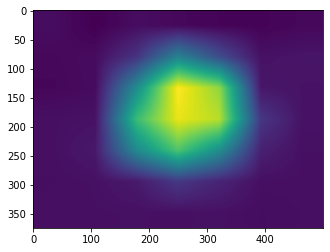

In [21]:
# CAM 생성

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

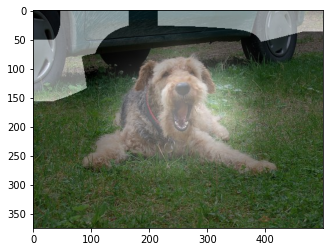

In [22]:
# CAM 이미지를 원본 이미지와 합침 : addWeighted( )

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)

    # cv2.addWeighted()를 이용해 두 개의 이미지를 합침
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

# 원본 이미지는 데이터셋에서 가져오고
origin_image = item['image'].astype(np.uint8)

# 생성된 CAM은 3채널.. np.stack()을 활용해 채널별로 만들어진 CAM합쳐줌
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

# 원본이미지와 CAM을 합쳐줌
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()


## STEP 4. Grad-CAM 모델 생성
* Grad-CAM을 이용해서 CAM을 얻어봄
* 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용

67


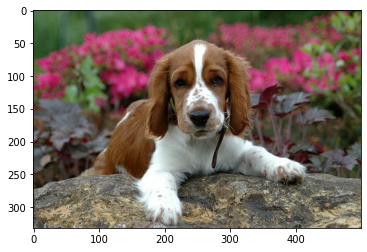

In [23]:
# 새로운 이미지 뽑아봄

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### S4-1. Grad-CAM

In [24]:
# Grad-CAM을 이용해 CAM을 생성하는 함수 정의

def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


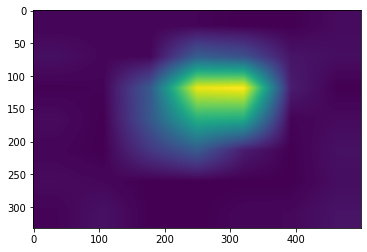

In [25]:
# 만든 함수로 여러 레이어의 CAM 이미지를 구해 봄

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

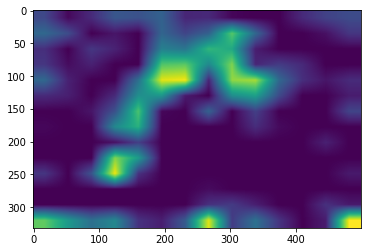

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

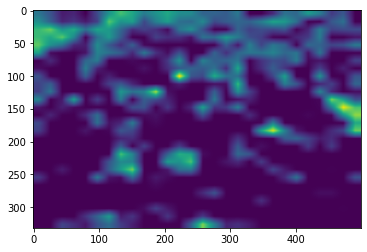

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## STEP 5. CAM을 활용해 Detection 해 봄


67


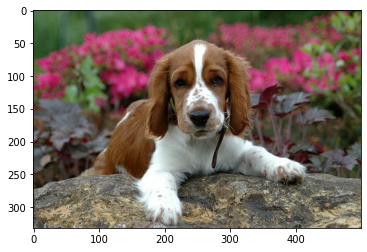

In [29]:
# 새로운 이미지 뽑아서

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

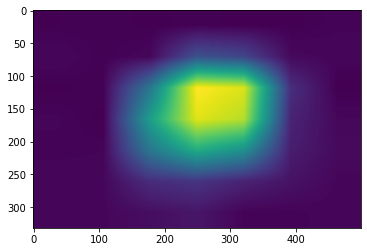

In [30]:
# CAM 생성

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

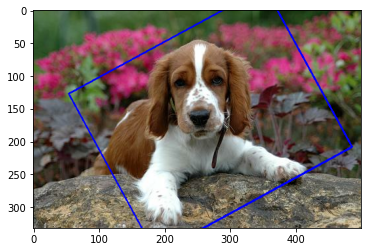

In [31]:
# 바운딩박스 만들어 주기

# 바운딩박스 좌표 구하는 함수 : 
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh  # 역치값 이하의 바운딩박스는 없앰
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # 사각형 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # 회전된 바운딩박스 얻음

    # 회전된 바운딩박스를 꼭짓점으로 바꾸어줌
    rect = cv2.boxPoints(rotated_rect)

    # int 자료형으로 변환해줌
    rect = np.int0(rect)
    return rect

# 좌표 구하기
rect = get_bbox(cam_image)
rect

# 바운딩박스 그려주기
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()


In [32]:
# 바둔딩박스 좌표를 minmax 형태로 치환하는 함수 정의

# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


In [33]:
# 위에서 구했던 rect를 minmax 형태로 치환해 줌

pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.10542168674698796, 0.108, 1.1174698795180722, 0.972]

In [34]:
# 이 데이터의 ground truth bbox를 확인해 봄

item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [35]:
# IoU를 계산해 봄

# IoU 계산하는 함수 정의

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# IoU 계산

get_iou(pred_bbox, item['objects']['bbox'][0])

0.5485996953317924

---
# STAGE II. 프로젝트
---

## STEP 0. 환경 설정 & 이미지 준비


In [36]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.2
1.21.6
4.6.0
7.1.2


In [37]:
# 이미지 가져오는 함수 정의

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


80


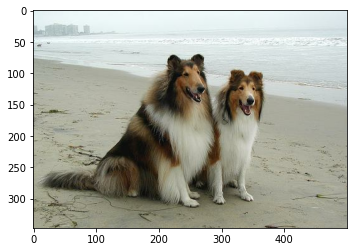

In [38]:
# 이미지 확인

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

## STEP 1. CAM 구현하기


In [39]:
def generate_cam(model, item):  # model과 item을 받는 함수 선언
    item = copy.deepcopy(item)  # item을 받아서 deepcopy로 item 생성
    width = item['image'].shape[1]  # item에서 shape[1]은 widht
    height = item['image'].shape[0]  # item에서 shape[0]은 height
    
		# 전처리 함수에서 전처리한 img_tensor와 객체 인덱스를 받음
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줌.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


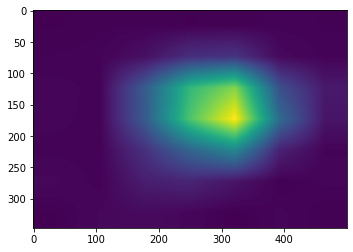

In [40]:
# CAM 생성
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)


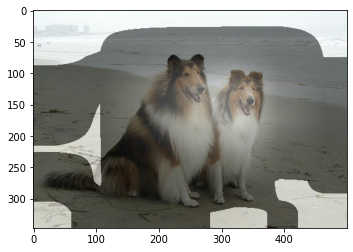

In [41]:
# CAM 이미지를 원본 이미지와 합침 : addWeighted( )

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)

    # cv2.addWeighted()를 이용해 두 개의 이미지를 합침
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

# 원본 이미지는 데이터셋에서 가져오고
origin_image = item['image'].astype(np.uint8)

# 생성된 CAM은 3채널.. np.stack()을 활용해 채널별로 만들어진 CAM합쳐줌
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

# 원본이미지와 CAM을 합쳐줌
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

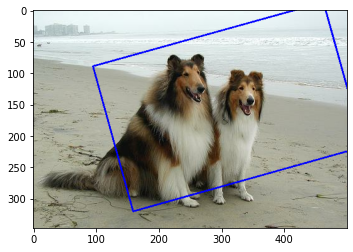

In [42]:
# 바운딩박스 만들어 주기

# 바운딩박스 좌표 구하는 함수 : 
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh  # 역치값 이하의 바운딩박스는 없앰
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # 사각형 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # 회전된 바운딩박스 얻음

    # 회전된 바운딩박스를 꼭짓점으로 바꾸어줌
    rect = cv2.boxPoints(rotated_rect)

    # int 자료형으로 변환해줌
    rect = np.int0(rect)
    return rect

# 좌표 구하기
rect = get_bbox(cam_image)
rect

# 바운딩박스 그려주기
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()


In [43]:
# 바둔딩박스 좌표를 minmax 형태로 치환하는 함수 정의

# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [44]:
# 위에서 구했던 rect를 minmax 형태로 치환해 줌

pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.037463976945244955, 0.19, 0.9221902017291066, 1.052]

In [45]:
# 이 데이터의 ground truth bbox를 확인해 봄

item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [46]:
# IoU를 계산해 봄

# IoU 계산하는 함수 정의

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# IoU 계산

get_iou(pred_bbox, item['objects']['bbox'][0])

0.2902337126355394

## STEP 2. Grad-CAM 구현하기

In [47]:
# Grad-CAM 구현

def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

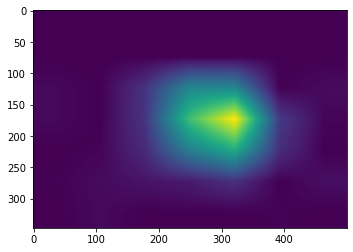

In [48]:
# 만든 함수로 여러 레이어의 CAM 이미지를 구해 봄1

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

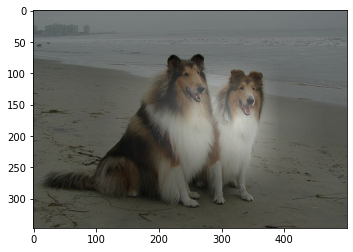

In [49]:
# CAM 이미지를 원본 이미지와 합침 : addWeighted( )

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)

    # cv2.addWeighted()를 이용해 두 개의 이미지를 합침
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

# 원본 이미지는 데이터셋에서 가져오고
origin_image = item['image'].astype(np.uint8)

# 생성된 Grad_CAM은 3채널.. np.stack()을 활용해 채널별로 만들어진 CAM합쳐줌
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

# 원본이미지와 CAM을 합쳐줌
blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

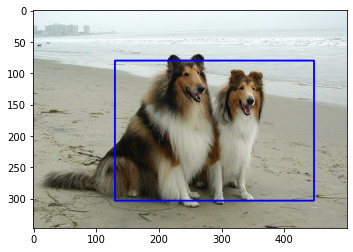

In [58]:
# 바운딩박스 만들어 주기

# 바운딩박스 좌표 구하는 함수 : 
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh  # 역치값 이하의 바운딩박스는 없앰
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # 사각형 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # 회전된 바운딩박스 얻음

    # 회전된 바운딩박스를 꼭짓점으로 바꾸어줌
    rect = cv2.boxPoints(rotated_rect)

    # int 자료형으로 변환해줌
    rect = np.int0(rect)
    return rect

# 좌표 구하기
rect_grad = get_bbox(grad_cam_image)
rect_grad

# 바운딩박스 그려주기
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_grad], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [59]:
# 바둔딩박스 좌표를 minmax 형태로 치환하는 함수 정의

# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [60]:
# 위에서 구했던 rect를 minmax 형태로 치환해 줌

pred_bbox_grad = rect_to_minmax(rect_grad, item['image'])
pred_bbox_grad

[0.23054755043227665, 0.26, 0.8731988472622478, 0.894]

In [61]:
# 이 데이터의 ground truth bbox를 확인해 봄

item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [63]:
# IoU를 계산해 봄

# IoU 계산하는 함수 정의

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# IoU 계산

get_iou(pred_bbox_grad, item['objects']['bbox'][0])

0.34136596846798206

## [ 루브릭 ]

1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?

  * ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.

2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?

 * CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.

3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?

 * CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

 IoU_cam      = 0.2902337126355394
 IoU_grad-cam = 0.34136596846798206

## [ 회고 ]

* cam과 grad-cam을 적용한 결과를 비교해서 차이를 확인해 볼 수 있었음.

* CAM 이전까지 CNN에 대한 학습과정에서 어떻게 최종적인 결과를 구하게 되는가, 즉 이미지 분류 모델에서 최종적인 결과가 도출되는 과정에 대한 부분에 대해 궁금증이 많았는데, CAM에서는 그런 의문에서 착안해 훈련과정에서 생성된 피처맵이 물체의 특징을 반영한 것에 착안해서 이로부터 CAM 방법론까지 도출해 낸 것에 대해 연구하는 태도와 기술의 발전이 어떻게 이루어지는지 생각해 보게 됨